# Import Libraries

In [41]:
from ContinuousDeepRobots import ThreeLinkRobot
import random
import copy
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from math import pi, log
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Define DQNAgent Class

In [54]:
class DQNAgent:
    INPUT_DIM = 5
    OUTPUT_DIM = 1
    def __init__(self, actions_params=(-pi/16, pi/16, pi/128), memory_size=500, gamma=0.9995, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.actions = self._get_actions(actions_params)
        self.model = self._build_model()

    def _get_actions(self, actions_params):
        """
        :return: a list of action space values in tuple format (a1dot, a2dot)
        """
        lower_limit, upper_limit, interval = actions_params
        upper_limit += (interval/10)  # to ensure the range covers the rightmost value in the loop
        r = np.arange(lower_limit, upper_limit, interval)
        actions = [(i, j) for i in r for j in r]

        # remove a1dot = 0, a2dot = 0 from action space
        actions.remove((0.0,0.0))

        return actions
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        # input layer
        model.add(Dense(250, input_dim=self.INPUT_DIM, activation='relu'))
        # hidden layers
        model.add(Dense(500, activation='relu'))
        model.add(Dense(250, activation='relu'))
        # output layer
        model.add(Dense(self.OUTPUT_DIM, activation = 'linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def choose_action(self, robot, state, epsilon_greedy=False):
        """
        epsilon-greedy approach for choosing an action and transition into next state
        returns the next state, reward resulting from the chosen action
        """
        chosen_action = None
        if epsilon_greedy:
            if np.random.rand() <= self.epsilon:
                # print('random actions')
                # choose random action
                while True:
                    chosen_action = random.choice(self.actions)
                    temp_robot = copy.deepcopy(robot)
                    _, a1, a2 = temp_robot.move(chosen_action)
                    if a1 - a2 > 0.001 and -pi/2 <= a1 <= pi/2 and -pi/2 <= a2 <= pi/2:
                        break
            else:
                # print('argmax')
                # find the action with greatest Q value
                maxQ = -float("inf")
                for action in self.actions:
                    input_data = np.asarray(state + action).reshape(1, 5)
                    Q = self.model.predict(input_data)        
                    if Q > maxQ:
                        temp_robot = copy.deepcopy(robot)
                        _, a1, a2 = temp_robot.move(action)
                        # print('a1 - a2 > 0.00001: ', a1 - a2 > 0.00001, '-pi/2 <= a1 <= pi/2: ', -pi/2 <= a1 <= pi/2, '-pi/2 <= a2 <= pi/2: ', -pi/2 <= a2 <= pi/2)
                        if a1 - a2 > 0.00001 and -pi/2 <= a1 <= pi/2 and -pi/2 <= a2 <= pi/2:
                            maxQ = Q
                            chosen_action = action
        else:
            
            # policy rollout
            maxQ = -float("inf")
                for action in self.actions:
                    input_data = np.asarray(state + action).reshape(1, 5)
                    Q = self.model.predict(input_data)        
                    if Q > maxQ:
                        maxQ = Q
                        chosen_action = action
                     
        return chosen_action
    
    def act(self, robot, action):
        
        # transition into next state
        next_state = robot.move(action=action)
        
        # calculate reward
        a1, a2, v, a1dot, a2dot = robot.a1, robot.a2, robot.body_v[0], robot.a1dot, robot.a2dot
        reward = v/(a1dot**2 + a2dot**2)
        
        return robot, reward, next_state

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        losses = []
        for state, action, reward, next_state in minibatch:
            
            # perform Bellman Update (use temporal difference?)
            input_data = np.asarray(state + action).reshape(1, 5)
            # print('reward: ', reward, 'prediction: ', self.model.predict(input_data))
            Q_target = reward + self.gamma * self.model.predict(input_data)
            
            # perform a gradient descent step
            loss = self.model.train_on_batch(input_data, Q_target)
            # print('loss: ', loss, 'input: ', input_data, 'Q_target: ', Q_target)
            losses.append(loss)
            # self.model.fit(state, target_f, epochs=1, verbose=0)
            
        # update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # return the average lost of this experience replay
        return sum(losses)/len(losses)
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

IndentationError: unexpected indent (<ipython-input-54-3f59fdecb47c>, line 80)

# DeepRobots

In [55]:
EPISODES = 10
ITERATIONS = 100

agent = DQNAgent()
batch_size = 10

for e in range(1,EPISODES+1):
    robot = ThreeLinkRobot()
    state = robot.randomize_state()
    for i in range(1,ITERATIONS+1):
        # print('In ', e, ' th epsiode, ', i, ' th iteration, the initial state is: ', state)
        action = agent.choose_action(robot, state, epsilon_greedy=True)
        # print('In ', e, ' th epsiode, ', i, ' th iteration, the chosen action is: ', action)
        robot_after_transition, reward, next_state = agent.act(robot, action)
        # print('In ', e, ' th epsiode, ', i, ' th iteration, the state after transition is: ', next_state)
        agent.remember(state, action, reward, next_state)
        state = next_state
        robot = robot_after_transition
        if len(agent.memory) > batch_size:
            avg_loss = agent.replay(batch_size)
            print('In ', e, ' th episode, ', i, ' th iteration, the average loss is: ', avg_loss)
            
        # print('\n')

In  1  th episode,  11  th iteration, the average loss is:  496.84675312
In  1  th episode,  12  th iteration, the average loss is:  599.033562088
In  1  th episode,  13  th iteration, the average loss is:  331.366205502
In  1  th episode,  14  th iteration, the average loss is:  478.679350615
In  1  th episode,  15  th iteration, the average loss is:  381.334587955
In  1  th episode,  16  th iteration, the average loss is:  476.00259428
In  1  th episode,  17  th iteration, the average loss is:  174.384111595
In  1  th episode,  18  th iteration, the average loss is:  429.908905053
In  1  th episode,  19  th iteration, the average loss is:  4654.27657242
In  1  th episode,  20  th iteration, the average loss is:  5800.24889798
In  1  th episode,  21  th iteration, the average loss is:  1536.54578319
In  1  th episode,  22  th iteration, the average loss is:  4613.47976735
In  1  th episode,  23  th iteration, the average loss is:  1459.07423659
In  1  th episode,  24  th iteration, th

In  2  th episode,  23  th iteration, the average loss is:  91372.2673397
In  2  th episode,  24  th iteration, the average loss is:  1644.03970622
In  2  th episode,  25  th iteration, the average loss is:  873.987570542
In  2  th episode,  26  th iteration, the average loss is:  203.707767439
In  2  th episode,  27  th iteration, the average loss is:  283103.601387
In  2  th episode,  28  th iteration, the average loss is:  6678.64238735
In  2  th episode,  29  th iteration, the average loss is:  302.57541281
In  2  th episode,  30  th iteration, the average loss is:  312.728109026
In  2  th episode,  31  th iteration, the average loss is:  1170.98408737
In  2  th episode,  32  th iteration, the average loss is:  6589.923386
In  2  th episode,  33  th iteration, the average loss is:  2986.13728117
In  2  th episode,  34  th iteration, the average loss is:  356.403582191
In  2  th episode,  35  th iteration, the average loss is:  235.79991436
In  2  th episode,  36  th iteration, the 

In  3  th episode,  34  th iteration, the average loss is:  266816.777807
In  3  th episode,  35  th iteration, the average loss is:  91329.1225777
In  3  th episode,  36  th iteration, the average loss is:  48536.9224723
In  3  th episode,  37  th iteration, the average loss is:  221174.537888
In  3  th episode,  38  th iteration, the average loss is:  110412.173838
In  3  th episode,  39  th iteration, the average loss is:  2460.94246559
In  3  th episode,  40  th iteration, the average loss is:  651639.413
In  3  th episode,  41  th iteration, the average loss is:  374068.407724
In  3  th episode,  42  th iteration, the average loss is:  564694.543527
In  3  th episode,  43  th iteration, the average loss is:  408553.010432
In  3  th episode,  44  th iteration, the average loss is:  208392.21857
In  3  th episode,  45  th iteration, the average loss is:  242965.437732
In  3  th episode,  46  th iteration, the average loss is:  241467.102258
In  3  th episode,  47  th iteration, the 

In  4  th episode,  46  th iteration, the average loss is:  551641.201027
In  4  th episode,  47  th iteration, the average loss is:  180784.832559
In  4  th episode,  48  th iteration, the average loss is:  123397.724124
In  4  th episode,  49  th iteration, the average loss is:  190855.950792
In  4  th episode,  50  th iteration, the average loss is:  528993.87168
In  4  th episode,  51  th iteration, the average loss is:  164503.631586
In  4  th episode,  52  th iteration, the average loss is:  444647.119854
In  4  th episode,  53  th iteration, the average loss is:  165528.741566
In  4  th episode,  54  th iteration, the average loss is:  770025.616528
In  4  th episode,  55  th iteration, the average loss is:  207922.130357
In  4  th episode,  56  th iteration, the average loss is:  120482.734051
In  4  th episode,  57  th iteration, the average loss is:  362850.786304
In  4  th episode,  58  th iteration, the average loss is:  192680.243896
In  4  th episode,  59  th iteration, t

In  5  th episode,  57  th iteration, the average loss is:  308931.766187
In  5  th episode,  58  th iteration, the average loss is:  392173.278566
In  5  th episode,  59  th iteration, the average loss is:  288550.013548
In  5  th episode,  60  th iteration, the average loss is:  341009.6396
In  5  th episode,  61  th iteration, the average loss is:  318394.52787
In  5  th episode,  62  th iteration, the average loss is:  213238.341788
In  5  th episode,  63  th iteration, the average loss is:  309302.895601
In  5  th episode,  64  th iteration, the average loss is:  218325.282524
In  5  th episode,  65  th iteration, the average loss is:  233453.062109
In  5  th episode,  66  th iteration, the average loss is:  221061.780727
In  5  th episode,  67  th iteration, the average loss is:  385567.052681
In  5  th episode,  68  th iteration, the average loss is:  292988.101773
In  5  th episode,  69  th iteration, the average loss is:  137809.344446
In  5  th episode,  70  th iteration, the

In  6  th episode,  68  th iteration, the average loss is:  97282.9139525
In  6  th episode,  69  th iteration, the average loss is:  160518.313225
In  6  th episode,  70  th iteration, the average loss is:  127518.383887
In  6  th episode,  71  th iteration, the average loss is:  155962.217542
In  6  th episode,  72  th iteration, the average loss is:  130421.61678
In  6  th episode,  73  th iteration, the average loss is:  58827.4837231
In  6  th episode,  74  th iteration, the average loss is:  134708.215133
In  6  th episode,  75  th iteration, the average loss is:  127858.693595
In  6  th episode,  76  th iteration, the average loss is:  60206.9488396
In  6  th episode,  77  th iteration, the average loss is:  84735.9233124
In  6  th episode,  78  th iteration, the average loss is:  288315.336273
In  6  th episode,  79  th iteration, the average loss is:  62840.1485996
In  6  th episode,  80  th iteration, the average loss is:  54939.7187454
In  6  th episode,  81  th iteration, t

In  7  th episode,  79  th iteration, the average loss is:  70643.0950256
In  7  th episode,  80  th iteration, the average loss is:  54383.9111427
In  7  th episode,  81  th iteration, the average loss is:  169613.853181
In  7  th episode,  82  th iteration, the average loss is:  108484.355935
In  7  th episode,  83  th iteration, the average loss is:  59412.7074951
In  7  th episode,  84  th iteration, the average loss is:  54644.1843384
In  7  th episode,  85  th iteration, the average loss is:  22185.2496368
In  7  th episode,  86  th iteration, the average loss is:  73843.5316589
In  7  th episode,  87  th iteration, the average loss is:  11480.563884
In  7  th episode,  88  th iteration, the average loss is:  26928.5835938
In  7  th episode,  89  th iteration, the average loss is:  185649.195035
In  7  th episode,  90  th iteration, the average loss is:  13364.8517269
In  7  th episode,  91  th iteration, the average loss is:  39177.6517609
In  7  th episode,  92  th iteration, t

In  8  th episode,  90  th iteration, the average loss is:  13992.3112922
In  8  th episode,  91  th iteration, the average loss is:  23196.5819458
In  8  th episode,  92  th iteration, the average loss is:  44966.7941206
In  8  th episode,  93  th iteration, the average loss is:  3328.16059341
In  8  th episode,  94  th iteration, the average loss is:  19446.3549103
In  8  th episode,  95  th iteration, the average loss is:  31526.024115
In  8  th episode,  96  th iteration, the average loss is:  23249.0417765
In  8  th episode,  97  th iteration, the average loss is:  3366.19024811
In  8  th episode,  98  th iteration, the average loss is:  9492.46069827
In  8  th episode,  99  th iteration, the average loss is:  27815.2100954
In  8  th episode,  100  th iteration, the average loss is:  32082.7316452
In  9  th episode,  1  th iteration, the average loss is:  9550.99504957
In  9  th episode,  2  th iteration, the average loss is:  4809.07836965
In  9  th episode,  3  th iteration, the

In  10  th episode,  1  th iteration, the average loss is:  1855.24678802
In  10  th episode,  2  th iteration, the average loss is:  1049.12473033
In  10  th episode,  3  th iteration, the average loss is:  1143.07083893
In  10  th episode,  4  th iteration, the average loss is:  3386.37470207
In  10  th episode,  5  th iteration, the average loss is:  870.196243286
In  10  th episode,  6  th iteration, the average loss is:  402.712975025
In  10  th episode,  7  th iteration, the average loss is:  9415.07217196
In  10  th episode,  8  th iteration, the average loss is:  519.325942516
In  10  th episode,  9  th iteration, the average loss is:  4686.7429636
In  10  th episode,  10  th iteration, the average loss is:  266.991323966
In  10  th episode,  11  th iteration, the average loss is:  1665.96327524
In  10  th episode,  12  th iteration, the average loss is:  566.461627173
In  10  th episode,  13  th iteration, the average loss is:  56218.0461438
In  10  th episode,  14  th iterati

# Policy Rollout

In [51]:
def make_graphs(xs, a1s, a2s, steps):
    
    # plotting
    fig1 = plt.figure(1)
    fig1.suptitle('Policy Rollout')
    ax1 = fig1.add_subplot(311)
    ax2 = fig1.add_subplot(312)
    ax3 = fig1.add_subplot(313)
    fig2 = plt.figure(2)
    fig2.suptitle('a1 vs a2')
    ax4 = fig2.add_subplot(111)
    
    ax1.plot(steps, xs, '.-')
    ax1.set_ylabel('x')
    ax1.set_xlabel('steps')
    ax2.plot(steps, a1s, '.-')
    ax2.set_ylabel('a1')
    ax2.set_xlabel('steps')
    ax3.plot(steps, a2s, '.-')
    ax3.set_ylabel('a2')
    ax3.set_xlabel('steps')
    ax4.plot(a1s,a2s,'.-')
    ax4.set_xlabel('a1')
    ax4.set_ylabel('a2')
    
    fig1.tight_layout()
    fig2.tight_layout()
    plt.tight_layout()
    plt.show()

In 1 th iteration the initial state is:  (0, 0.19634954084936207, -0.19634954084936207)
In 1 th iteration the chosen action is:  (0.024543692606170259, -0.19634954084936207)
In 1 th iteration, the robot moved  0.44274120520315774  in x direction
In 2 th iteration the initial state is:  (0.03121531258256096, 0.22089323345553233, -0.39269908169872414)
In 2 th iteration the chosen action is:  (0.024543692606170259, -0.19634954084936207)
In 2 th iteration, the robot moved  0.29190630514636595  in x direction
In 3 th iteration the initial state is:  (0.051180120357766395, 0.2454369260617026, -0.5890486225480862)
In 3 th iteration the chosen action is:  (0.024543692606170259, -0.19634954084936207)
In 3 th iteration, the robot moved  0.22479373593592644  in x direction
In 4 th iteration the initial state is:  (0.06648360572096443, 0.2699806186678728, -0.7853981633974483)
In 4 th iteration the chosen action is:  (0.024543692606170259, -0.19634954084936207)
In 4 th iteration, the robot moved  0

In 34 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 34 th iteration, the robot moved  0.012396452380907697  in x direction
In 35 th iteration the initial state is:  (0.36076105150916976, -0.0736310778185108, -1.5707963267948966)
In 35 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 35 th iteration, the robot moved  0.012782941763975098  in x direction
In 36 th iteration the initial state is:  (0.37254632947088834, -0.09817477042468106, -1.5707963267948966)
In 36 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 36 th iteration, the robot moved  0.01317262875656633  in x direction
In 37 th iteration the initial state is:  (0.3841530033429964, -0.12271846303085132, -1.5707963267948966)
In 37 th iteration the chosen action is:  (0.19634954084936207, 0.0)
In 37 th iteration, the robot moved  -0.10852719094384033  in x direction
In 38 th iteration the initial state is:  (0.2927993506730743, 0.07363107781851075, -1.5707963267948966)

In 67 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 67 th iteration, the robot moved  0.011161707703637891  in x direction
In 68 th iteration the initial state is:  (0.3486253549859759, -2.7755575615628914e-17, -1.5707963267948966)
In 68 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 68 th iteration, the robot moved  0.011533611151132384  in x direction
In 69 th iteration the initial state is:  (0.36089720128906105, -0.024543692606170286, -1.5707963267948966)
In 69 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 69 th iteration, the robot moved  0.01190751156676062  in x direction
In 70 th iteration the initial state is:  (0.3730146992825691, -0.049087385212340545, -1.5707963267948966)
In 70 th iteration the chosen action is:  (-0.024543692606170259, 0.0)
In 70 th iteration, the robot moved  0.01228368911790989  in x direction
In 71 th iteration the initial state is:  (0.3849701255500751, -0.0736310778185108, -1.57079632679

In 100 th iteration the chosen action is:  (0.19634954084936207, 0.0)
In 100 th iteration, the robot moved  -0.10657174771790245  in x direction


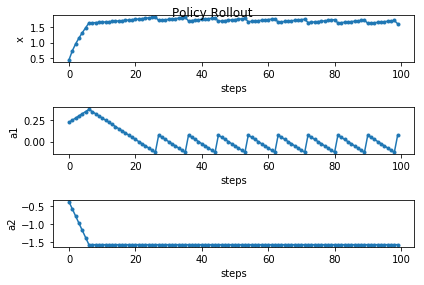

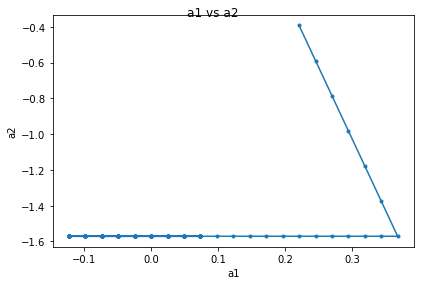

In [56]:
TIMESTEPS = 100
xs = []
a1s = []
a2s = []
steps = []
dx = 0
robot = ThreeLinkRobot()
for i in range(TIMESTEPS):

    # rollout
    state = robot.state
    print('In', i+1, 'th iteration the initial state is: ', state)
    old_x = robot.x
    action = agent.choose_action(robot, state)
    print('In', i+1, 'th iteration the chosen action is: ', action)
    robot.move(action=action)
    new_x = robot.x
    print('In', i+1, 'th iteration, the robot moved ', new_x - old_x, ' in x direction')
    dx += (new_x-old_x)

    # add values to lists
    xs.append(dx)
    a1s.append(robot.a1)
    a2s.append(robot.a2)
    steps.append(i)

# plotting
make_graphs(xs,a1s,a2s,steps)


# OpenAI CartPole 

In [ ]:
EPISODES = 1000

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        # env.render()
        action = agent.act(state)
        # print(f'action:{action}')
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    # if e % 10 == 0: